In [ ]:
import sys
sys.path.append('..')

In [1]:
import torch
import PIL
import os
import cv2
from scipy import ndimage
import numpy as np
from PIL import Image
import torchvision
from torchvision import transforms
from src.efficientunet import *
import random
import matplotlib.pyplot as plt
from src.dataset import  RetinalDataset
from src.model import get_torchvision_model
import src.segmentation_models_pytorch as smp
from scipy.ndimage.morphology import binary_dilation, binary_erosion
from src.utils import binarize_phi


SCALE = 256

## Load model

In [2]:
model = get_torchvision_model("Se_resnext50", True, 1, "focal")

In [3]:
state_dict = torch.load("models/Se_resnext50-920eef84.pth",  map_location=torch.device('cpu'))
state_dict = state_dict["state"]
model.load_state_dict(state_dict)

<All keys matched successfully>

## Load depedencies

In [4]:
# Transformation
from src.transformation import train_transformation, inference_transformation

# FAZ Preprocessing
from src.dataset import FAZ_Preprocess

# Level Set
from src.levelset import *

# Metrics
from src.metrics import scoring

# Handy ultility function
from src.utils import binarize_phi

## Predict and Visualization: step by step

### Load image

(<matplotlib.axes._subplots.AxesSubplot at 0x16e963ef0>,
 Text(0.5, 1.0, 'Ground truth mask'),
 (-0.5, 303.5, 303.5, -0.5))

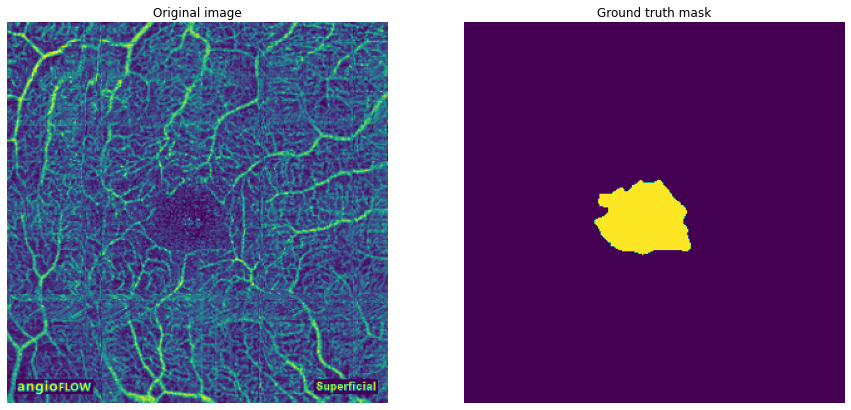

In [5]:
# Load image
imagename = 'JC_10584_Angio_Retina_OD_3x3b_superficial' 
impath = 'images/samples/raw/' + imagename + '.tif'
im = plt.imread(impath)

labelpath = 'images/samples/mask/' + imagename + '.png'
label = plt.imread(labelpath)

plt.figure(figsize=(15,10)), plt.axis('off')
plt.subplot(1,2,1), plt.imshow(im), plt.title('Original image'), plt.axis('off')
plt.subplot(1,2,2), plt.imshow(label), plt.title('Ground truth mask'), plt.axis('off')

### Enhanced by Hessian-based filter

In [6]:
# Loading image and ENHANCE by Hessian-based filter
enhanced = FAZ_Preprocess(impath,[0.5,1, 1.5, 2, 2.5],1, 2).vesselness2d()

(<matplotlib.image.AxesImage at 0x16ee05198>,
 (-0.5, 303.5, 303.5, -0.5),
 Text(0.5, 1.0, 'Enhanced by Hessian filter'))

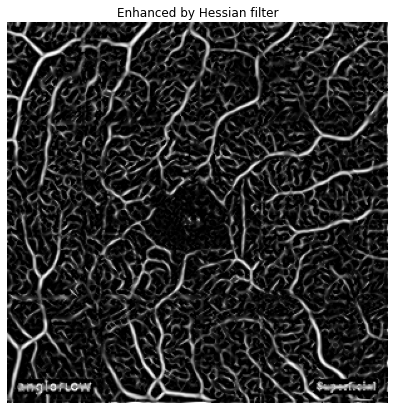

In [7]:
plt.figure(figsize=(13,7))
plt.imshow(enhanced, cmap='gray'), plt.axis('off'), plt.title('Enhanced by Hessian filter')

### Segment (predict) using DNN

In [8]:
# Transformation (to tensor)
tensor_transform = transforms.Compose([
    transforms.Resize((SCALE, SCALE)),
    transforms.ToTensor()
])

enhanced_ts = tensor_transform(Image.fromarray(enhanced.astype(np.float32)*255).convert("RGB"))

enhanced_ts.shape

torch.Size([3, 256, 256])

In [9]:
model.eval()
mask = enhanced_ts.unsqueeze(0)
mask = model(mask)
mask = (mask.to("cpu").detach().numpy() > 0.6) * 1
mask = mask.reshape((SCALE, SCALE))

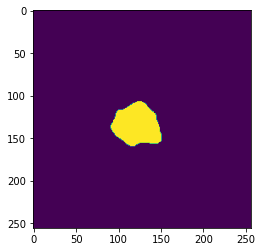

In [10]:
plt.imshow(mask)

((-0.5, 255.5, 255.5, -0.5), Text(0.5, 1.0, 'Mask predicted by UNet'))

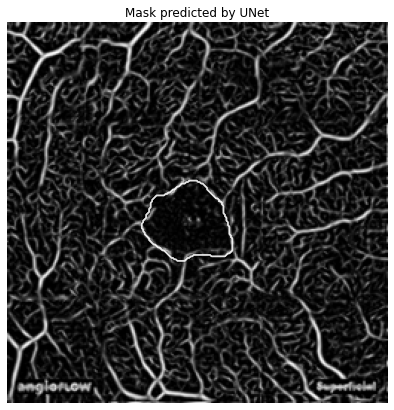

In [11]:
enhanced_scaled = enhanced_ts.permute(1,2,0).numpy()
enhanced_scaled =  cv2.cvtColor(enhanced_scaled, cv2.COLOR_RGB2GRAY)

plt.figure(figsize=(13,7))
plt.imshow(enhanced_scaled, cmap='gray')
#plt.imshow(mask, cmap='gray', alpha=0.3)
plt.contour(mask, levels=np.logspace(-4.7, -3., 10), colors='white', alpha=0.2)
plt.axis('off'), plt.title('Mask predicted by UNet')

In [12]:
# Measure performance of the current step
label_PIL = Image.fromarray(label.astype(np.float32)*255).convert("RGB")
label_ts = tensor_transform(label_PIL) # convert label to the same size with mask, equal to `size` defined above
scoring(label_ts.to("cpu").numpy(), mask)

(0.82, -1.87, 0.09)

### LEVEL SET

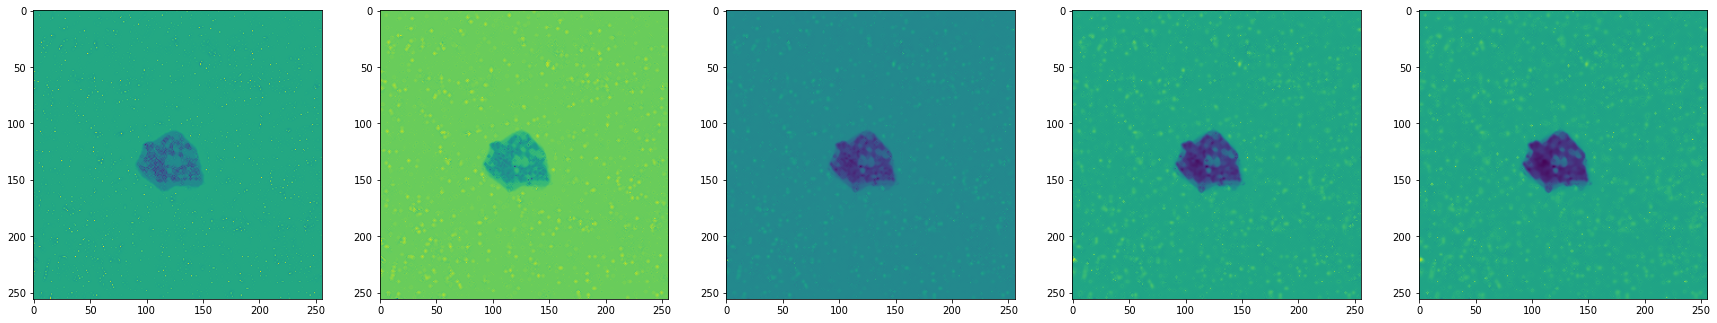

In [13]:
phi, delta = levelset(enhanced_ts, mask, 5, isplot=True)

(<matplotlib.image.AxesImage at 0x16f51b710>,
 (-0.5, 255.5, 255.5, -0.5),
 Text(0.5, 1.0, 'Mask predicted by DNN, erosed a little, after LEVELSET'))

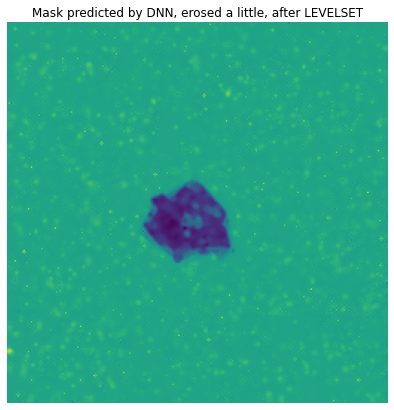

In [14]:
plt.figure(figsize=(13,7))
plt.imshow(phi), plt.axis('off'), plt.title('Mask predicted by DNN, erosed a little, after LEVELSET')

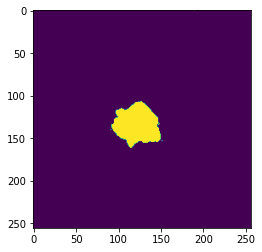

In [15]:
binary_phi = binarize_phi(phi)
plt.imshow(binary_phi)

((-0.5, 255.5, 255.5, -0.5),
 Text(0.5, 1.0, 'Mask predicted by UNet + LevelSet'))

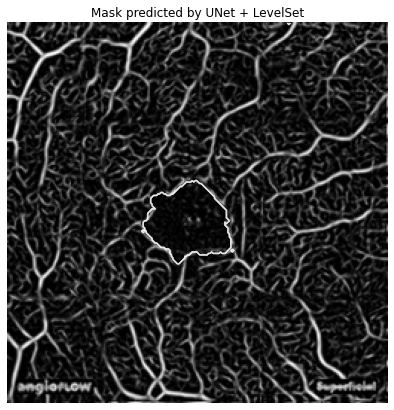

In [16]:
plt.figure(figsize=(13,7))
plt.imshow(enhanced_scaled, cmap='gray')
#plt.imshow(new_phi, cmap='gray', alpha=0.3)
plt.contour(binary_phi, levels=np.logspace(-4.7, -3., 10), colors='white', alpha=0.2)
plt.axis('off'), plt.title('Mask predicted by UNet + LevelSet')

In [17]:
# Measure performance of the current step
scoring(label_ts.to("cpu").numpy(), binary_phi)

(0.79, -1.91, 0.14)

### Erosion + Levelset

In [18]:
# EROSE the output mask
kernel1 = np.array([[0, 0, 1, 0, 0],
           [0, 1, 1, 1, 0],
           [1, 1, 1, 1, 1],
           [0, 1, 1, 1, 0],
           [0, 0, 1, 0, 0]])   
kernel2 = np.ones((5,5))

erosed_mask = binary_erosion(mask.copy(), kernel2, iterations = 3)

(<matplotlib.image.AxesImage at 0x170a7ea90>,
 (-0.5, 255.5, 255.5, -0.5),
 Text(0.5, 1.0, 'Mask predicted by DNN, erosed a little'))

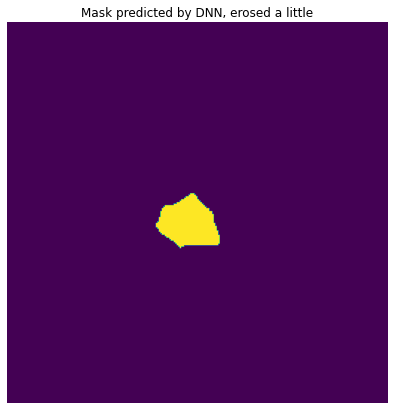

In [19]:
plt.figure(figsize=(13,7))
plt.imshow(erosed_mask), plt.axis('off'), plt.title('Mask predicted by DNN, erosed a little')

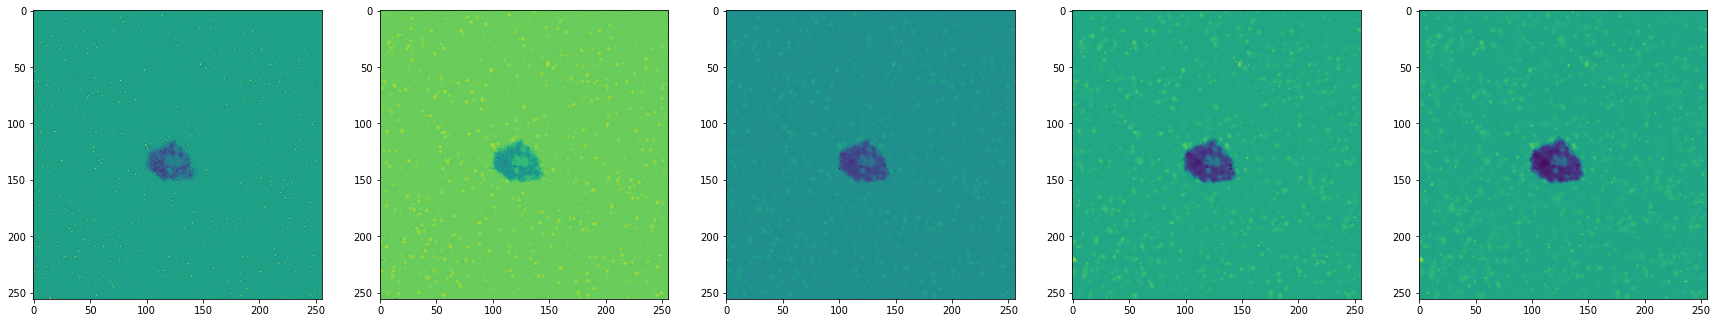

In [20]:
phi2, delta2 = levelset(enhanced_ts, erosed_mask, 5, isplot=True)

In [21]:
binary_phi2 = binarize_phi(phi2)

((-0.5, 255.5, 255.5, -0.5),
 Text(0.5, 1.0, 'Mask predicted by UNet + LevelSet'))

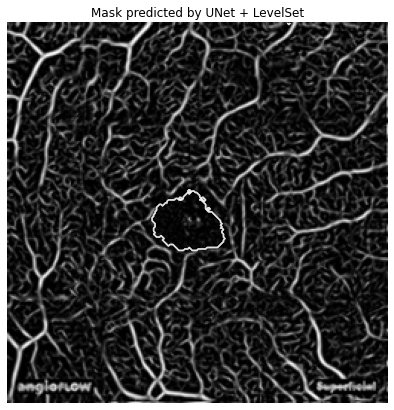

In [22]:
plt.figure(figsize=(13,7))
plt.imshow(enhanced_scaled, cmap='gray')
#plt.imshow(new_phi, cmap='gray', alpha=0.3)
plt.contour(binary_phi2, levels=np.logspace(-4.7, -3., 10), colors='white', alpha=0.2)
plt.axis('off'), plt.title('Mask predicted by UNet + LevelSet')

In [23]:
# Measure performance of the current step
scoring(label_ts.to("cpu").numpy(), binary_phi2)

(0.51, -2.0, 0.46)

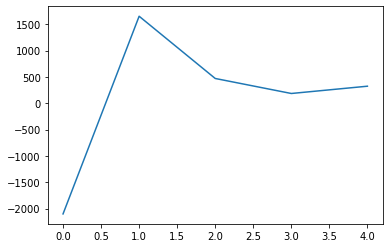

In [24]:
plt.plot(delta2)

In [25]:
delta2

array([-2102.49316258,  1652.09612584,   470.0871388 ,   184.93203135,
         323.29373689])

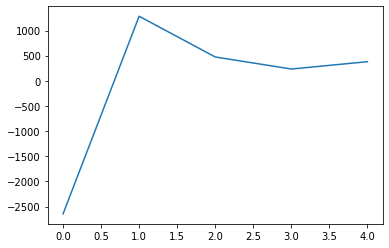

In [26]:
plt.plot(delta)

In [27]:
delta

array([-2647.16850097,  1283.65396199,   473.77011278,   234.19870096,
         379.74677769])

In [28]:
delta[-1] - delta[-2]

145.5480767249115

In [29]:
delta2[-1] - delta2[-2]

138.36170553580277

In [37]:
145/(256**2) * 100

0.22125244140625

In [34]:
256**2

65536